## Autonomous Multi-Agent System for Enhanced Automotive User Experience

#### Capstone Project - Kaggle 5-Day Generative AI Course

### Install Required Libaries

In [1]:
!pip uninstall -qqy kfp jupyterlab google-generativeai tensorflow-hub 2>/dev/null
!pip install -U -q langchain langchain-google-genai langgraph google-cloud-aiplatform pandas scikit-learn "langchain-community>=0.2.7" "langchain-core>=0.2.19"
!pip install -U -q google-cloud-speech
!pip install chromadb
!pip install "protobuf==3.20.3" -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 1

### Import Required Libraries

In [2]:
import os
import typing
import uuid
import math
import heapq
from collections.abc import Iterable
from random import randint
from pprint import pprint
import json
import re 

from langchain_core.messages.ai import AIMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from google.cloud import aiplatform
from langchain_community.embeddings import VertexAIEmbeddings
from langchain_community.vectorstores.matching_engine import MatchingEngine

from IPython.display import Image, display, Markdown

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache

### Retrieve the Google API key from Kaggle Secrets

In [3]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

### Initialize the Google Cloud AI Platform (Vertex AI)

In [4]:
PROJECT_ID = "capstone-project"
LOCATION = "us-central1"

try:
    aiplatform.init(project=PROJECT_ID, location=LOCATION)
    print(f"Vertex AI initialized for project {PROJECT_ID} in {LOCATION}.")
except Exception as e:
    print(f"Error initializing Vertex AI: {e}")

Vertex AI initialized for project capstone-project in us-central1.


### Setting Up RAG for Car Manual

In [5]:
car_manual_text = """
## Headlights

### Automatic Headlights
Your vehicle is equipped with automatic headlights. To enable this feature, rotate the headlight switch stalk (usually on the left of the steering wheel) to the 'AUTO' position. The headlights will then turn on automatically in low light conditions or when wipers are activated.

### Manual Headlight Operation
To operate the headlights manually, rotate the switch stalk:
- One click clockwise: Parking lights only.
- Two clicks clockwise: Low beam headlights.
- Pull the stalk towards you: High beam headlights (may flash or stay on depending on previous state). Push away to return to low beams.

## Tire Pressure Monitoring System (TPMS)

### Checking Tire Pressure
Your vehicle's recommended tire pressure is listed on the sticker inside the driver's side doorjamb. For most models, it is typically 35 PSI when tires are cold. Use a reliable pressure gauge to check pressure regularly, ideally monthly.

### TPMS Warning Light
If the TPMS warning light (often looks like a tire cross-section with an exclamation mark) illuminates on your dashboard, it indicates one or more tires are significantly under-inflated. Check all tire pressures as soon as possible and inflate them to the recommended PSI. The light may take some driving to reset after inflation. If the light flashes, it usually indicates a system malfunction; consult your dealer.

## Bluetooth Pairing

### Pairing a New Device
1. Ensure Bluetooth is enabled on your phone or audio device.
2. On the vehicle's infotainment screen, navigate to Settings > Bluetooth > Add Device.
3. The system will search for nearby devices. Select your device from the list.
4. A pairing code may be displayed on both the screen and your device. Confirm they match.
5. Accept the pairing request on your device.
6. Once paired, you can select the device for audio playback or phone calls.

### Troubleshooting Pairing
If pairing fails, try turning Bluetooth off and on again on both the vehicle and your device. Ensure your device is discoverable. Delete old pairings if you have reached the maximum number of devices. Consult the infotainment system manual for more detailed steps.

## Wipers

### Front Wipers
The wiper control stalk is typically on the right side of the steering column.
- Push down once for a single wipe (mist).
- Pull up one click for intermittent wipers. Rotate the band to adjust the delay.
- Pull up two clicks for low speed continuous wipers.
- Pull up three clicks for high speed continuous wipers.
- Push the end button to spray washer fluid on the front windshield.

### Rear Wiper (if equipped)
Usually controlled by twisting the end cap of the right stalk.
- Twist forward one position for intermittent rear wipe.
- Twist forward two positions for continuous rear wipe.
- Push the stalk away from you to spray rear washer fluid.
"""

vector_store = None
retriever = None
gemini_embeddings = None

try:
    gemini_embeddings = GoogleGenerativeAIEmbeddings(
        model="models/text-embedding-004",
        task_type="retrieval_document"
    )

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    doc_splits = [Document(page_content=chunk, metadata={"source": "car_manual_local"})
                  for chunk in text_splitter.split_text(car_manual_text)]
    print(f"Created {len(doc_splits)} document chunks.")

    if doc_splits:
        print("Creating in-memory ChromaDB vector store and adding documents...")
        vector_store = Chroma.from_documents(
            documents=doc_splits,
            embedding=gemini_embeddings,

        )

        retriever = vector_store.as_retriever(search_kwargs={"k": 3})
        print("ChromaDB retriever created.")
    else:
        print("No document splits generated, skipping vector store creation.")

except Exception as e:
    print(f"An error occurred during RAG setup: {e}")
    print("VehicleInfo tool might not function correctly.")

Created 8 document chunks.
Creating in-memory ChromaDB vector store and adding documents...
ChromaDB retriever created.


### Map Data Simulation

In [6]:
locations = {
    "Home": {"type": "residence", "x": 0, "y": 0},
    "Downtown Cafe": {"type": "coffee shop", "x": 10, "y": 5},
    "Tech Park Cafe": {"type": "coffee shop", "x": 45, "y": 35},
    "Main St Gas": {"type": "gas station", "x": 12, "y": 0},
    "Highway Gas Stop": {"type": "gas station", "x": 50, "y": 50},
    "Luigi's Pizza": {"type": "restaurant", "x": 9, "y": 8},
    "Ocean Sushi": {"type": "restaurant", "x": 25, "y": 18},
    "City Hall": {"type": "government", "x": 20, "y": 20},
    "Shopping Mall": {"type": "shopping", "x": 22, "y": 22},
    "Tech Park Work": {"type": "office", "x": 40, "y": 30},
    "Park Entrance": {"type": "park", "x": 18, "y": 25},
    "Library": {"type": "government", "x": 19, "y": 19}
}

connections = {
    "Home": {"Main St Gas": 12, "Downtown Cafe": 11, "Luigi's Pizza": 12},
    "Main St Gas": {"Home": 12, "Downtown Cafe": 2, "City Hall": 10},
    "Downtown Cafe": {"Home": 11, "Main St Gas": 2, "Luigi's Pizza": 1},
    "Luigi's Pizza": {"Downtown Cafe": 1, "Ocean Sushi": 16, "Library": 13},
    "City Hall": {"Main St Gas": 10, "Library": 1, "Shopping Mall": 2, "Park Entrance": 6, "Ocean Sushi": 7},
    "Library": {"Luigi's Pizza": 13, "City Hall": 1},
    "Shopping Mall": {"City Hall": 2, "Park Entrance": 3, "Ocean Sushi": 5},
    "Park Entrance": {"City Hall": 6, "Shopping Mall": 3, "Tech Park Work": 15},
    "Ocean Sushi": {"Luigi's Pizza": 16, "City Hall": 7, "Shopping Mall": 5, "Tech Park Work": 18},
    "Tech Park Work": {"Ocean Sushi": 18, "Park Entrance": 15, "Tech Park Cafe": 5, "Highway Gas Stop": 12},
    "Tech Park Cafe": {"Tech Park Work": 5, "Highway Gas Stop": 10},
    "Highway Gas Stop": {"Tech Park Cafe": 10, "Tech Park Work": 12}
}

nodes_to_update = {}
for node, neighbours in connections.items():
    for neighbour, distance in neighbours.items():
        if neighbour not in connections:
             nodes_to_update[neighbour] = {}
        if node not in connections.get(neighbour, {}):
             if neighbour not in nodes_to_update: nodes_to_update[neighbour] = {}
             nodes_to_update[neighbour][node] = distance
connections.update(nodes_to_update)

current_location_name = "Home"

def find_shortest_path(graph, start, end):
    """Finds the shortest path between start and end nodes using Dijkstra."""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous_nodes = {node: None for node in graph}
    priority_queue = [(0, start)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        if current_node == end:
            break

        if current_node not in graph:
             continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current = end
    if distances[current] == float('inf'):
        return None, float('inf')

    while current is not None:
        path.append(current)
        current = previous_nodes[current]
    path.reverse()

    return path, distances[end]

### Define Structure of the AgentState for the LangGraph agent

In [7]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    current_request: str | None
    last_agent_response: str | None
    route_decision: Literal["Navigation", "Media", "Communication", "VehicleInfo", "Respond", "Error", None]
    vehicle_context: list[str] | None
    navigation_context: dict | None
    media_context: dict | None
    communication_context: dict | None
    error: str | None
    final_response_generated: bool

## Tools

In [8]:
@tool
def navigation_tool(action: str, destination: str | None = None, poi_type: str | None = None) -> str:
    """
    Handles navigation tasks using a local graph map dataset.
    Actions: 'find_poi', 'start_navigation', 'get_traffic'.
    Requires 'poi_type' for 'find_poi' (e.g., 'coffee shop', 'gas station').
    Requires 'destination' name (must match a key in the 'locations' dictionary) for 'start_navigation'.
    'get_traffic' action is simplified.
    """
    print(f"--- TOOL CALL: navigation_tool (Action: {action}, Destination: {destination}, POI: {poi_type}) ---")
    global current_location_name
    global locations
    global connections

    current_loc_details = locations.get(current_location_name)
    if not current_loc_details:
        return "Error: Current location unknown or invalid."
    current_x = current_loc_details["x"]
    current_y = current_loc_details["y"]

    try:
        if action == "find_poi":
            if poi_type:
                found_pois = []
                poi_type_lower = poi_type.lower()
                for name, details in locations.items():
                    if details["type"] == poi_type_lower:
                        path, distance = find_shortest_path(connections, current_location_name, name)
                        if path:
                            found_pois.append({"name": name, "distance": distance, "path": path})

                if not found_pois:
                    return f"Sorry, I couldn't find any reachable '{poi_type}' from {current_location_name} using the available roads."

                found_pois.sort(key=lambda p: p["distance"])
                nearest_poi = found_pois[0]
                return (f"Found '{poi_type}': '{nearest_poi['name']}' is the closest reachable one "
                        f"(distance: {nearest_poi['distance']:.1f} units via {', '.join(nearest_poi['path'])}).")
            else:
                 return "Error: Please specify a type of place (POI) to find (e.g., 'coffee shop')."

        elif action == "start_navigation":
            if destination:
                if destination == current_location_name:
                    return f"You are already at {destination}."

                if destination in locations:
                    path, distance = find_shortest_path(connections, current_location_name, destination)
                    if path:
                        current_location_name = destination
                        print(f"   INFO: Simulating navigation. Current location updated to {destination}")
                        first_step = path[1] if len(path) > 1 else destination
                        return (f"Starting navigation to {destination}. "
                                f"Estimated travel distance: {distance:.1f} units. "
                                f"Route: {', '.join(path)}. First head towards {first_step}.")
                    else:
                        return f"Sorry, I couldn't find a route in the local map data from {current_location_name} to {destination}."
                else:
                    return f"Sorry, I don't have '{destination}' in my local map data."
            else:
                 return "Error: Please specify a destination for navigation."

        elif action == "get_traffic":
             if destination:
                 if destination in locations:
                      path, distance = find_shortest_path(connections, current_location_name, destination)
                      if distance > 20:
                          return f"Simulated: Traffic towards {destination} looks heavy based on distance."
                      else:
                          return f"Simulated: Traffic towards {destination} looks moderate."
                 else:
                     return f"Cannot check traffic for unknown destination: {destination}"
             else:
                 return "Simulated: Traffic in the current area appears moderate."

        else:
            return f"Error: Invalid navigation action '{action}'. Use 'find_poi', 'start_navigation', or 'get_traffic'."

    except Exception as e:
        print(f"   ERROR during local navigation tool execution: {e}")
        return f"Sorry, I encountered an internal error using the local navigation tool."


@tool
def media_tool(action: str, query: str | None = None) -> str:
    """
    Simulates interaction with a Media API.
    Actions can be 'play', 'pause', 'search_music', 'search_podcast'.
    Requires query for search actions.
    """
    print(f"--- TOOL CALL: media_tool (Action: {action}, Query: {query}) ---")
    if action == "play" and query:
        return f"Simulated: Playing '{query}'."
    elif action == "play":
        return f"Simulated: Resuming playback."
    elif action == "pause":
        return "Simulated: Pausing media."
    elif action == "search_music" and query:
        return f"Simulated: Found music matching '{query}'."
    elif action == "search_podcast" and query:
         return f"Simulated: Found podcasts matching '{query}'."
    else:
        return "Simulated: Invalid media action or missing query."

@tool
def communication_tool(action: str, recipient: str | None = None, message: str | None = None) -> str:
    """
    Simulates interaction with a Communication API (e.g., SMS, Email).
    Actions can be 'send_message', 'read_last_message'.
    Requires recipient and message for 'send_message'.
    """
    print(f"--- TOOL CALL: communication_tool (Action: {action}, Recipient: {recipient}) ---")
    if action == "send_message" and recipient and message:
        return f"Simulated: Sending message '{message}' to {recipient}."
    elif action == "read_last_message":
        return "Simulated: Last message reads 'On my way!'"
    else:
        return "Simulated: Invalid communication action or missing parameters."

@tool
def get_vehicle_info(query: str) -> str:
    """
    Provides information about the vehicle's features and functions by
    searching the local car manual vector store using RAG. It first retrieves
    relevant chunks and then uses an LLM to validate their relevance to the specific query
    before returning the information. Use this for questions about how to operate
    the car or troubleshoot issues.
    """
    print(f"--- TOOL CALL: get_vehicle_info (Query: {query}) ---")
    global retriever
    global llm

    if not retriever:
        print("   ERROR: Local vector store retriever is not available.")
        if "headlight" in query.lower():
            return "Simulated Fallback: To turn on the headlights, rotate the dial on the left stalk clockwise."
        elif "tire pressure" in query.lower():
             return "Simulated Fallback: Recommended tire pressure is 35 PSI for all tires."
        else:
            return "Error: The vehicle information system (manual search) is currently unavailable."

    try:
        print(f"   Searching local vector store for: '{query}'")
        relevant_docs = retriever.invoke(query)

        if not relevant_docs:
             print("   No relevant documents found in local store.")
             return "I looked through the manual, but couldn't find specific information for that query."

        print(f"   Found {len(relevant_docs)} potentially relevant chunks. Validating relevance...")

        formatted_chunks = ""
        for i, doc in enumerate(relevant_docs):
            source = doc.metadata.get('source', 'unknown')
            formatted_chunks += f"Chunk {i+1} (Source: {source}):\n{doc.page_content}\n\n---\n\n"

        validation_prompt = f"""
        User Query: "{query}"

        Here are potentially relevant chunks retrieved from the car manual:
        --- START CHUNKS ---
        {formatted_chunks}
        --- END CHUNKS ---

        Review these chunks carefully. Determine if any of them *directly* and *specifically* answer the user's query.

        Respond with ONLY ONE of the following:
        1. If one or more chunks directly answer the query: Respond with the full text of the single MOST relevant chunk. If multiple chunks are needed *together* to form the complete answer, combine their text concisely and accurately. Do NOT add any explanation like "Yes, this chunk answers...". Just provide the relevant text from the manual chunk(s).
        2. If NONE of the chunks directly answer the specific query: Respond with the exact phrase "No relevant information found".
        """

        try:
            validation_response = llm.invoke([HumanMessage(content=validation_prompt)])
            validated_content = validation_response.content.strip()

            if "No relevant information found" in validated_content:
                print("   LLM Validation: No directly relevant chunks found.")
                return "I found some potentially related information in the manual, but nothing that specifically answers your question about '{query}'." # <<< Specific negative response
            else:
                print("   LLM Validation: Found relevant chunk(s).")
                return f"Based on the local manual: {validated_content}"

        except Exception as e_val:
            print(f"   ERROR during LLM validation step: {e_val}")
            context = "\n\n---\n\n".join([f"(Source: {doc.metadata.get('source', 'unknown')}) {doc.page_content}" for doc in relevant_docs])
            print("   Validation failed, returning raw retrieved context as fallback.")
            return f"Retrieved Context from Local Manual (validation failed):\n{context}"

    except Exception as e_ret:
        print(f"   ERROR during local vector store search: {e_ret}")
        return f"Sorry, I encountered a technical error while searching the vehicle manual: {e_ret}. Please try rephrasing your question."

available_tools = [navigation_tool, media_tool, communication_tool, get_vehicle_info]

### Initializes the primary language model

In [9]:
set_llm_cache(InMemoryCache())

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

llm_with_tools = llm.bind_tools(available_tools)

### Defines the core agent functions (nodes)

In [10]:
def voice_interface_agent(state: AgentState) -> AgentState:
    """Captures user input. Prints the AI's last message first."""
    print("--- NODE: Voice Interface ---")
    messages = state['messages']
    if messages and isinstance(messages[-1], AIMessage):
         print("\nAssistant:")
         if messages[-1].content:
              print(f"   {messages[-1].content}")
         else:
              print("   (Assistant provided no text content)")

    user_input = input("\nUser Input: ") # Prompt user
    if user_input.lower().strip() in ['q', 'quit', 'exit', 'goodbye', 'stop']:
         print("   Exiting conversation.")
         return {"messages": [HumanMessage(content=user_input)], "final_response_generated": True}

    return {"messages": [HumanMessage(content=user_input)], "current_request": user_input, "final_response_generated": False, "error": None, "route_decision": None}


def orchestrator_agent(state: AgentState) -> AgentState:
    """
    Uses the LLM to decide the next step: plan, ask for clarification,
    call a tool, respond directly, or flag an error.
    The LLM's response might contain tool calls or be a direct message.
    """
    print("--- NODE: Orchestrator (LLM Based - Enhanced) ---")
    messages = state['messages']

    orchestrator_system_prompt = """You are the central orchestrator for an advanced automotive AI assistant.
Your goal is to meticulously analyze the user's request and the conversation history to determine the best next step.

Consider the following options:
1.  **Plan & Execute First Step:** If the request requires multiple actions or information from different tools, first formulate a concise internal thought outlining the necessary steps (e.g., "Thought: I need to find the location first, then get traffic for that route."). After the thought, immediately make the *first* required tool call by invoking the appropriate tool function.
2.  **Ask for Clarification:** If the user's request is ambiguous, incomplete, or requires information you don't have (like current location if not provided), ask a clear clarifying question to the user instead of calling a tool.
3.  **Call Single Tool:** If the request is clear and requires a single tool call to gather necessary information, make that tool call directly by invoking the appropriate tool function.
4.  **Respond Directly:** If you have enough information from the conversation history or a previous tool's result to fully answer the user's query, or if the query is purely conversational, generate the final helpful response directly as text content.
5.  **Use Available Tools:** You have access to tools for 'Navigation' (finding POIs, getting routes/traffic), 'Media' (playback, search), 'Communication' (messaging), and 'VehicleInfo' (searching the car manual). Only use these tools.

**Response Format:**
- If invoking a tool, ensure the tool call is structured correctly using the tool invocation mechanism. Include a preceding "Thought:" in the text content *only* if planning multi-step actions before the tool call. Do not add extra conversational text after the tool call invocation itself.
- If asking for clarification or responding directly, provide only the conversational text as your response content.

--- REVISED FEW-SHOT EXAMPLES START ---

*Example 1 (Navigation POI):*
User Input: "Where's the closest gas station?"
Your Action: Invoke the `navigation_tool` with arguments: `action="find_poi"`, `poi_type="gas station"`.

*Example 2 (Vehicle Info):*
User Input: "How do I pair my phone with Bluetooth?"
Your Action: Invoke the `get_vehicle_info` tool with argument: `query="how to pair phone with bluetooth"`.

*Example 3 (Media):*
User Input: "Play some rock music."
Your Action: Invoke the `media_tool` with arguments: `action="play"`, `query="rock music"`.

*Example 4 (Ambiguous):*
User Input: "Tell me about the drive."
Your Action (Clarification): Respond with text content: "What about the drive would you like to know? Are you asking about traffic, the route, or something else?"

*Example 5 (Conversation):*
User Input: "Okay thanks."
Your Action (Direct Response): Respond with text content: "You're welcome! Is there anything else I can help with?"

*Example 6 (Multi-step planning):*
User Input: "Find the Tech Park Cafe and check the traffic there."
Your Action: First provide the Thought in text content, then invoke the `navigation_tool`.
Content: "Thought: The user wants to find a specific location and then check traffic to it. First, I need to use the navigation tool to confirm the location exists and maybe get the route. Then I can check traffic. I will start by finding the POI or attempting navigation."
Tool Invocation: `navigation_tool` with arguments: `action="start_navigation"`, `destination="Tech Park Cafe"`.


--- REVISED FEW-SHOT EXAMPLES END ---

Now, analyze the current user request and conversation history based on these principles and examples. Make sure to use the actual tool invocation mechanism when a tool is needed, don't just write the JSON structure into the content.
"""

    llm_input_messages = [AIMessage(content=orchestrator_system_prompt), *messages]
    llm_response = llm_with_tools.invoke(llm_input_messages)

    print(f"   Orchestrator LLM Response Type: {type(llm_response)}")
    if hasattr(llm_response, 'tool_calls') and llm_response.tool_calls:
        print(f"   Tool Calls Planned: {[tc['name'] for tc in llm_response.tool_calls]}")
        if llm_response.content and "Thought:" in llm_response.content:
            print(f"   Preceding Thought: {llm_response.content}")
    else:
        print(f"   Direct Response/Clarification Planned: {llm_response.content[:100]}...")

    return {"messages": [llm_response]}


navigation_node = ToolNode([navigation_tool])
media_node = ToolNode([media_tool])
communication_node = ToolNode([communication_tool])
vehicle_info_node = ToolNode([get_vehicle_info])

def response_agent(state: AgentState) -> AgentState:
    """Generates/formats the final response for the user for the current turn."""
    print("--- NODE: Response Agent ---")
    messages = state['messages']
    last_message = messages[-1] if messages else None
    final_response_content = "Sorry, I'm not sure how to respond to that."

    if isinstance(last_message, AIMessage):
        final_response_content = last_message.content
        print(f"   Displaying final response: {final_response_content[:100]}...")
    elif isinstance(last_message, ToolMessage):
        tool_name = last_message.name
        tool_content = last_message.content
        print(f"   Formatting response based on result from tool: {tool_name}")
        if tool_name == "navigation_tool" and "Route:" in tool_content and "Starting navigation" in tool_content:
             try:
                  route_part = tool_content.split("Route: ")[1].split(". First head towards")[0]
                  destination = tool_content.split("Starting navigation to ")[1].split(".")[0]
                  distance_part = tool_content.split("distance: ")[1].split(" units")[0]
                  final_response_content = (f"Okay, starting navigation to {destination}. "
                                           f"The route is: {route_part}. "
                                           f"The total distance is about {distance_part} units.")
             except: final_response_content = f"Okay, I'm starting the navigation. ({tool_content})"
        elif tool_name == "get_vehicle_info" and "Retrieved Context" in tool_content:
             final_response_content = f"Based on the manual: {tool_content.split('Local Manual:')[-1].strip()[:200]}..."
        elif "Error:" in tool_content or "Sorry," in tool_content:
             final_response_content = tool_content
        else:
             final_response_content = f"Tool {tool_name} completed. Result: {tool_content}"
    else:
        print("   Warning: Response Agent received unexpected message type.")
        final_response_content = "I seem to be a bit confused."

    return {"messages": [AIMessage(content=final_response_content)], "final_response_generated": False}

print("Response Agent updated (final_response_generated=False).")

def error_node(state: AgentState) -> AgentState:
    """Handles errors and informs the user."""
    print("--- NODE: Error Handler ---")
    error_message = state.get('error', 'An unknown error occurred.')
    response = AIMessage(content=f"Sorry, I encountered an error: {error_message}. Please try again.")
    return {"messages": [response], "final_response_generated": True}

Response Agent updated (final_response_generated=False).


## Define Graph Edges and Conditional Routing

In [11]:
def select_route(state: AgentState) -> Literal["ExecuteTool", "Orchestrator", "ResponseAgent", "Error", "__end__"]:
    """
    Routes flow: checks exit flag FIRST, then other conditions.
    Specifically routes based on the type of the last message in the state.
    """
    print("--- ROUTING ---")

    if state.get("final_response_generated", False):
        print("   Decision: End of interaction signaled by final_response_generated flag.")
        return END

    messages = state['messages']
    last_message = messages[-1] if messages else None

    if state.get("error"):
        print(f"   Decision: Routing to Error Node due to error flag.")
        return "Error"

    if isinstance(last_message, ToolMessage):
        print("   Decision: Route to Orchestrator to process ToolMessage result.")
        return "Orchestrator"

    elif isinstance(last_message, HumanMessage):
        print("   Decision: Route to Orchestrator to process HumanMessage (relying on model's context window).")
        return "Orchestrator"

    elif isinstance(last_message, AIMessage):
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            print(f"   Decision: Route to ExecuteTool for calls: {[tc['name'] for tc in last_message.tool_calls]}")
            return "ExecuteTool"
        else:
            print("   Decision: Route to ResponseAgent to show final response to user.")
            return "ResponseAgent"

    else:
         print(f"   Decision: Fallback - Ending interaction due to unexpected state (last msg type: {type(last_message)}).")
         return END

## Build Graph

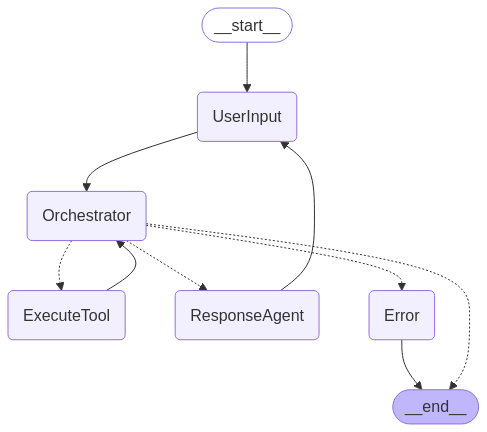

In [12]:
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("UserInput", voice_interface_agent)
graph_builder.add_node("Orchestrator", orchestrator_agent)
tool_executor_node = ToolNode(available_tools)
graph_builder.add_node("ExecuteTool", tool_executor_node)
graph_builder.add_node("ResponseAgent", response_agent)
graph_builder.add_node("Error", error_node)

# Define edges
graph_builder.add_edge(START, "UserInput")
graph_builder.add_edge("UserInput", "Orchestrator")

graph_builder.add_conditional_edges(
    "Orchestrator",
    select_route,
    {
        "ExecuteTool": "ExecuteTool",
        "ResponseAgent": "ResponseAgent",
        "Error": "Error",
        END: END
    }
)

graph_builder.add_edge("ExecuteTool", "Orchestrator")

graph_builder.add_edge("ResponseAgent", "UserInput")

graph_builder.add_edge("Error", END)

app_graph = graph_builder.compile()

display(Image(app_graph.get_graph().draw_mermaid_png()))

## Run the Agent System

In [13]:
config = {"recursion_limit": 30}

initial_state = {"messages": [], "final_response_generated": False}

try:
    final_state = app_graph.invoke(initial_state, config=config)
    print("\n--- Interaction Ended ---")
    print("\nFinal State:")
    pprint(final_state)
except Exception as e:
     print(f"\nAn error occurred during execution: {e}")

--- NODE: Voice Interface ---

An error occurred during execution: raw_input was called, but this frontend does not support input requests.
